In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```stack``` is the original stack as it is loaded from file<br>
```segchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```segchannel_smooth``` is the ```segchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```gradientimage``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
filename = '/Users/prakash/anaconda/envs/BobSegExtra/Data/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
#filename = '/Users/prakash/Dropbox/2018-04-13_fromMark/MAX_mNG-mSc_04_MEDIUM_UNCOUPLED.tif'
#filename = '/Users/prakash/Dropbox/2018-04-13_fromMark/MAX_mNG-mSc_05_MEDIUM_COUPLED.tif'

stack = imread(filename)
segchannel = stack[:,0,:,:]
flowchannel = stack[:,1,:,:]

sigma = [0.,2,2]
segchannel_smooth = gaussian(segchannel,sigma)
flowchannel_smooth = gaussian(flowchannel,[0.,1,1])

# gradientimage = np.minimum(flowchannel_smooth/np.mean(flowchannel_smooth), np.ones_like(flowchannel_smooth))
gradientimage = np.zeros_like(segchannel_smooth)
gradientimage += segchannel_smooth/np.max(segchannel_smooth)
gx = np.gradient(gradientimage, 25, axis=2)
gy = np.gradient(gradientimage, 25, axis=1)
gx = np.abs(gx)
gy = np.abs(gy)
gradientimage = gx+gy                  # add x and y gradients
gradientimage /= np.max(gradientimage) # normalizes such that largest value is 1.0
gradientimage **= .5                   # emphasizes smaller gradient values
gradientimage = gaussian(gradientimage,sigma)

T = len(segchannel)  # number of time-points

print('Shape of stack:', stack.shape)
print('Shape of flow channel:', flowchannel.shape)

Shape of stack: (75, 2, 356, 610)
Shape of flow channel: (75, 356, 610)


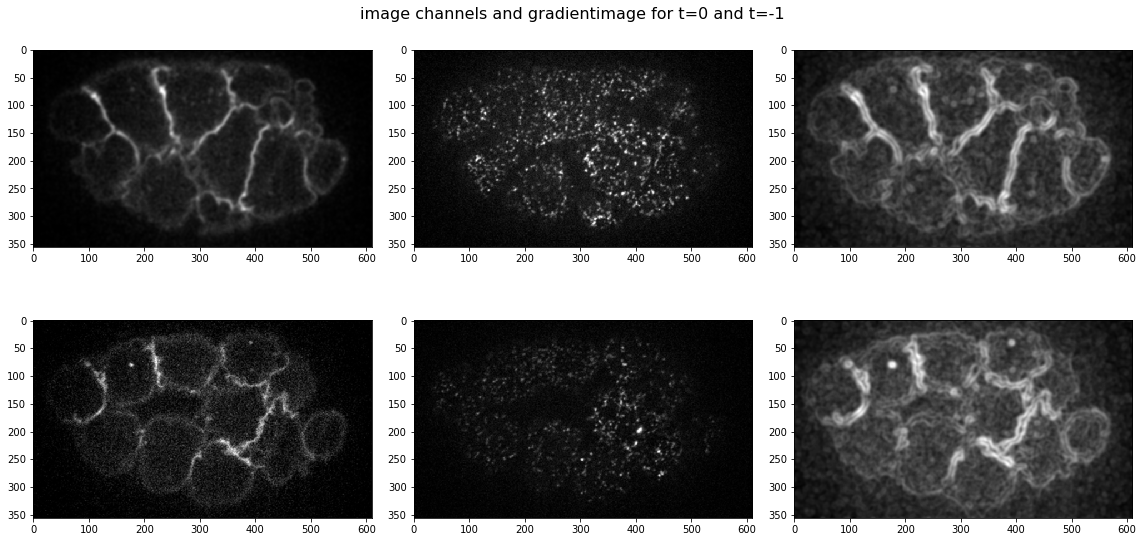

In [3]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
fig.tight_layout()

# Cell segmentation

In [4]:
# defining min and max radius for cell segmentation
max_rs = ((segchannel[0].shape[1] / 6),
          (segchannel[0].shape[1] / 6))

min_rs = (10,10)
print (min_rs, max_rs)

(10, 10) (101.66666666666667, 101.66666666666667)


In [5]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

In [6]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
data.add_object_at( cell_Ea, min_rs, max_rs, frame=0, seed=(330,200), segment_it=True )
data.track(cell_Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ea" in frame 0 with seed coordinates [ 330.  200.]
      Optimum energy:  24.612192525704348
      Nodes in/out:  4384 2816
      Area:  13409.0
Added appearance for "Ea" in frame 1 with seed coordinates [ 330.  200.]
      Optimum energy:  24.344324140802435
      Nodes in/out:  4219 2981
      Area:  12570.0
    Updated center to [ 337.08333333  201.83333333]
Added appearance for "Ea" in frame 2 with seed coordinates [ 337.  202.]
      Optimum energy:  23.182723121203196
      Nodes in/out:  4209 2991
      Area:  12306.5
    Updated center to [ 341.81944444  202.36111111]
Added appearance for "Ea" in frame 3 with seed coordinates [ 342.  202.]
      Optimum energy:  21.94001965665467
      Nodes in/out:  4554 2646
      Area:  14036.5
    Updated center to [ 343.19444444  198.73611111]
Added appearance for "Ea" in frame 4 with seed coordinates [ 343.  199.]
      Optimum energy:  23.56112705205323
      Nodes in/out:  4356 2844
      Area:  13016.5
    Updated

      Optimum energy:  22.06960714925476
      Nodes in/out:  4238 2962
      Area:  12202.0
    Updated center to [ 358.76388889  168.36111111]
Added appearance for "Ea" in frame 39 with seed coordinates [ 359.  168.]
      Optimum energy:  21.435675550669586
      Nodes in/out:  4174 3026
      Area:  11876.0
    Updated center to [ 358.01388889  167.20833333]
Added appearance for "Ea" in frame 40 with seed coordinates [ 358.  167.]
      Optimum energy:  22.776543489309844
      Nodes in/out:  4200 3000
      Area:  12037.0
    Updated center to [ 357.70833333  165.47222222]
Added appearance for "Ea" in frame 41 with seed coordinates [ 358.  165.]
      Optimum energy:  22.708152820694405
      Nodes in/out:  4337 2863
      Area:  12676.5
    Updated center to [ 357.01388889  165.55555556]
Added appearance for "Ea" in frame 42 with seed coordinates [ 357.  166.]
      Optimum energy:  22.922692664099966
      Nodes in/out:  4494 2706
      Area:  13500.5
    Updated center to [ 358

In [7]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
data.add_object_at( cell_Ep, min_rs, max_rs, frame=0, seed=(460,250), segment_it=True )
data.track(cell_Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ep" in frame 0 with seed coordinates [ 460.  250.]
      Optimum energy:  18.988558032646132
      Nodes in/out:  4169 3031
      Area:  12957.0
Added appearance for "Ep" in frame 1 with seed coordinates [ 460.  250.]
      Optimum energy:  18.309996714582713
      Nodes in/out:  4276 2924
      Area:  13542.0
    Updated center to [ 447.59722222  244.25      ]
Added appearance for "Ep" in frame 2 with seed coordinates [ 448.  244.]
      Optimum energy:  21.06240640223286
      Nodes in/out:  4661 2539
      Area:  14795.5
    Updated center to [ 444.02777778  238.86111111]
Added appearance for "Ep" in frame 3 with seed coordinates [ 444.  239.]
      Optimum energy:  19.867126051839445
      Nodes in/out:  4576 2624
      Area:  14398.0
    Updated center to [ 441.19444444  234.27777778]
Added appearance for "Ep" in frame 4 with seed coordinates [ 441.  234.]
      Optimum energy:  18.68437548881342
      Nodes in/out:  4599 2601
      Area:  14398.0
    Updated

      Nodes in/out:  4324 2876
      Area:  12750.0
    Updated center to [ 439.55555556  230.73611111]
Added appearance for "Ep" in frame 41 with seed coordinates [ 440.  231.]
      Optimum energy:  20.31002991807414
      Nodes in/out:  4277 2923
      Area:  12597.0
    Updated center to [ 440.94444444  230.52777778]
Added appearance for "Ep" in frame 42 with seed coordinates [ 441.  231.]
      Optimum energy:  19.23383058658766
      Nodes in/out:  3986 3214
      Area:  11163.5
    Updated center to [ 444.          228.23611111]
Added appearance for "Ep" in frame 43 with seed coordinates [ 444.  228.]
      Optimum energy:  19.31061318297328
      Nodes in/out:  4119 3081
      Area:  11684.0
    Updated center to [ 444.44444444  227.29166667]
Added appearance for "Ep" in frame 44 with seed coordinates [ 444.  227.]
      Optimum energy:  19.348136059031397
      Nodes in/out:  4063 3137
      Area:  11478.0
    Updated center to [ 445.76388889  225.55555556]
Added appearance fo

In [8]:
surface_coords_Ea = data.segment2dt( cell_Ea, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1695.2826698055937
      Area:  13334.5
Results for frame 1:
      Optimum energy:  1695.2826698055937
      Area:  13331.5
Results for frame 2:
      Optimum energy:  1695.2826698055937
      Area:  13295.0
Results for frame 3:
      Optimum energy:  1695.2826698055937
      Area:  13422.0
Results for frame 4:
      Optimum energy:  1695.2826698055937
      Area:  13632.0
Results for frame 5:
      Optimum energy:  1695.2826698055937
      Area:  13645.0
Results for frame 6:
      Optimum energy:  1695.2826698055937
      Area:  13676.0
Results for frame 7:
      Optimum energy:  1695.2826698055937
      Area:  13495.0
Results for frame 8:
      Optimum energy:  1695.2826698055937
      Area:  13407.0
Results for frame 9:
      Optimum energy:  1695.2826698055937
      Area:  13431.5
Results for frame 10:
      Optimum energy:  1695.2826698055937
      Area:  13467.0
Results for frame 11:
      Optimum energy:  1695.2826698055937
      Area:

In [9]:
surface_coords_Ep = data.segment2dt( cell_Ep, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1518.0583478501978
      Area:  14118.0
Results for frame 1:
      Optimum energy:  1518.0583478501978
      Area:  14099.0
Results for frame 2:
      Optimum energy:  1518.0583478501978
      Area:  14158.5
Results for frame 3:
      Optimum energy:  1518.0583478501978
      Area:  14310.5
Results for frame 4:
      Optimum energy:  1518.0583478501978
      Area:  14236.5
Results for frame 5:
      Optimum energy:  1518.0583478501978
      Area:  14327.5
Results for frame 6:
      Optimum energy:  1518.0583478501978
      Area:  14250.5
Results for frame 7:
      Optimum energy:  1518.0583478501978
      Area:  14388.5
Results for frame 8:
      Optimum energy:  1518.0583478501978
      Area:  14474.0
Results for frame 9:
      Optimum energy:  1518.0583478501978
      Area:  14661.5
Results for frame 10:
      Optimum energy:  1518.0583478501978
      Area:  14695.0
Results for frame 11:
      Optimum energy:  1518.0583478501978
      Area:

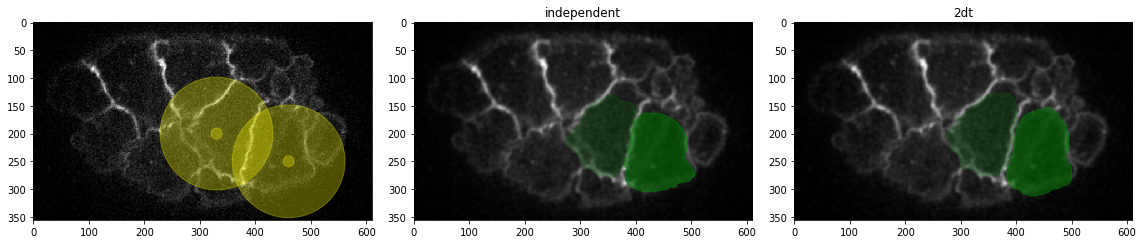

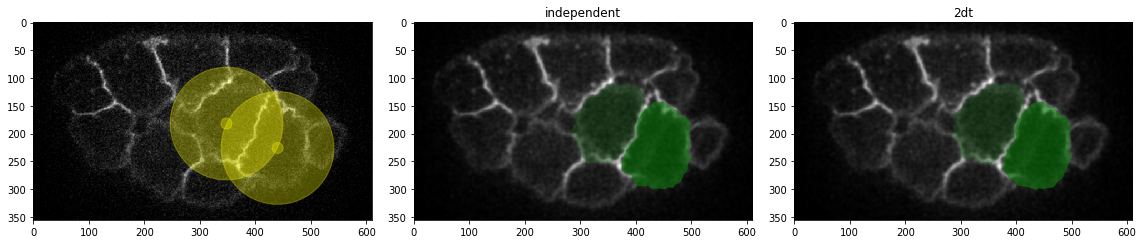

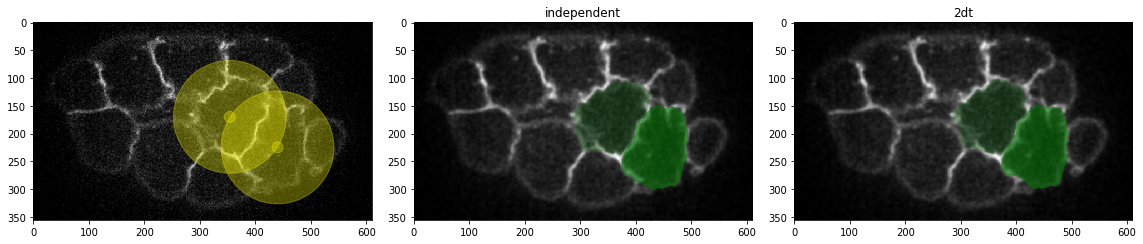

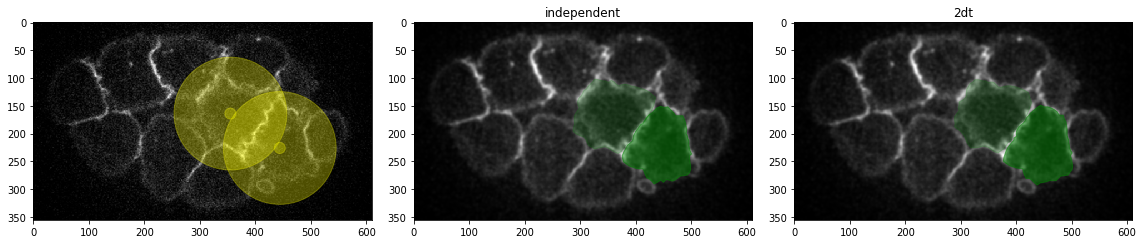

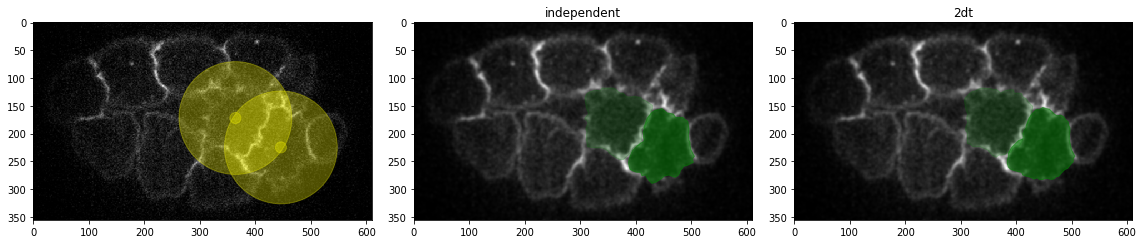

In [10]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(1,len(data.images),int(len(data.images)/5)):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax, segchannel )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax, segchannel_smooth )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax, segchannel_smooth )
    fig.tight_layout()

# Flow computation

In [11]:
flows = bsu.compute_flow( flowchannel )
flow_x, flow_y = bsu.split_flow_components( flows )

........................................................................... ...done!


In [12]:
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

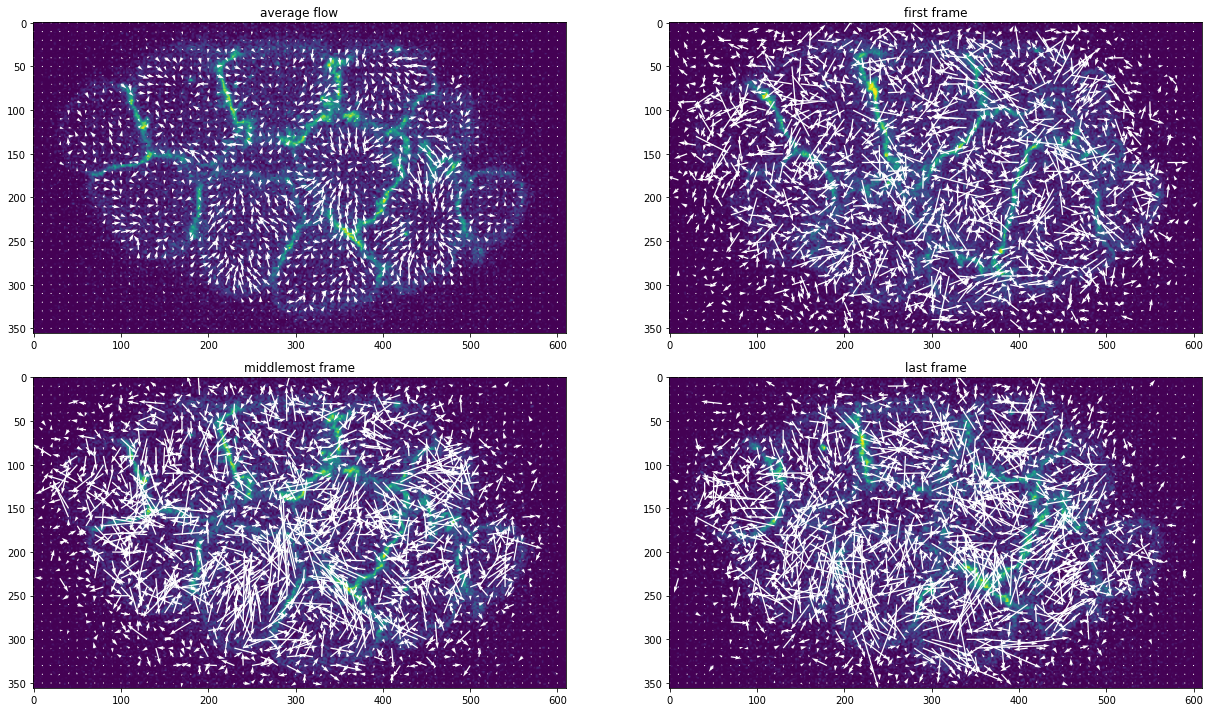

In [13]:
pylab.rcParams['figure.figsize'] = (18, 10)
fig = plt.figure()

y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]
skip = (slice(None, None, 10), slice(None, None, 10))

ax = plt.subplot(221)
ax.set_title('average flow')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],total_avg_flow_x[skip],-total_avg_flow_y[skip], color='w', scale=50)

ax = plt.subplot(222)
ax.set_title('first frame')
ax.imshow(segchannel[0])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[0][skip],-avg_flow_y[0][skip], color='w', scale=50)

ax = plt.subplot(223)
ax.set_title('middlemost frame')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[int(len(flowchannel)/2)][skip],-avg_flow_y[int(len(flowchannel)/2)][skip], color='w', scale=50)

ax = plt.subplot(224)
ax.set_title('last frame')
ax.imshow(segchannel[-1])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[-1][skip],-avg_flow_y[-1][skip], color='w', scale=50)

fig.tight_layout()
fig.savefig('test.pdf',dpi=300)

# Flow data crunching...

In [14]:
annulus_outer_factor = .85
annulus_inner_factor = .6

In [15]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T):
        membrane_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,1.0) )
        annulus_outer_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_outer_factor) )
        annulus_middle_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

In [16]:
def get_annulus_bresenham_lines(inner_polygone, outer_polygone):
    annulus_bresenham_lines = []
    for i in range(len(inner_polygone)):
        points = bham.bresenhamline( np.array([inner_polygone[i]]),np.array([outer_polygone[i]]) )
        annulus_bresenham_lines.append(points)
    return annulus_bresenham_lines

In [17]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

### compute membrane movement vectors

In [18]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:
    membrane_movement_vectors_per_frame = []
    for t in range(T-1):
        membrane_movement_vectors = []
        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        for i in range(len(poly_t1)):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

### compute averaged flow vectors

In [19]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            for point in line:
                sum_x += avg_flow_x[t,point[1],point[0]]
                sum_y += avg_flow_y[t,point[1],point[0]]
            avg_x = sum_x / len(line)
            avg_y = sum_y / len(line)
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [20]:
column_vectors = data.netsurfs[0][0].col_vectors # they are normalized to length 1

In [21]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T-1):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### compute frame averages and correlations for lineplots

In [22]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
correlation_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    correlation_per_frame = []
    for t in range(T-1):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        avg_membrane_contraction_per_frame.append( np.mean(memveclengths) )
        avg_center_flow_per_frame.append( np.mean( flowveclengths) )
        correlation_per_frame.append( pearsonr(memveclengths, flowveclengths)[0] )
        
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    correlation_per_frame_per_object.append( correlation_per_frame )

### initialize imaginary myosins

In [23]:
initialization_time = 0

In [24]:
initial_myo_pos_per_object = []
for obj in objects:
    initial_myo_pos_list = []
    for i in range(len(column_vectors)):
        initial_myo_pos_list.append(annulus_bresenham_lines_per_frame_per_object[obj][initialization_time][i])
    initial_myo_pos = [item for sublist in initial_myo_pos_list for item in sublist]
    initial_myo_pos_per_object.append(initial_myo_pos)
# initial_myo_pos_per_object = []
# for obj in objects:
#     initial_myo_pos_per_object.append(annulus_outer_polygones_per_object[obj][initialization_time])

### Tracking imaginary myosins over time

In [25]:
position_imaginary_myosins_per_frame_per_object = []
for obj in objects:
    position_imaginary_myosins_per_frame = []
    temporary_list = initial_myo_pos_per_object[obj]
    for t in range(initialization_time, T, 1):
        position_imaginary_myosin = []
        for myosin_count in range(len(temporary_list)):
            new_myosin_position = bsu.update_pos(temporary_list[myosin_count],t, avg_flow_x, avg_flow_y)
            position_imaginary_myosin.append(new_myosin_position)
            temporary_list[myosin_count] = new_myosin_position
        position_imaginary_myosins_per_frame.append(position_imaginary_myosin)
        
    position_imaginary_myosins_per_frame_per_object.append(position_imaginary_myosins_per_frame)

### Number crunching for plots

In [26]:
cumulative_myosin_dist_per_frame_per_object = []
for obj in objects:
    cumulative_myosin_dist_per_frame = []
    for frame in range(0,len(segchannel)-initialization_time,1):
        myosin_dist_from_center = 0

        for i in range(len(initial_myo_pos_per_object[obj])):
            dist2 = bsu.euclid_dist(position_imaginary_myosins_per_frame_per_object[obj][frame][i], data.object_seedpoints[obj][frame])
            myosin_dist_from_center = dist2 + myosin_dist_from_center

        cumulative_myosin_dist_per_frame.append(myosin_dist_from_center)   
    cumulative_myosin_dist_per_frame_per_object.append(cumulative_myosin_dist_per_frame)

In [27]:
cumulative_membrane_dist_per_frame_per_object = []
for obj in objects:
    cumulative_membrane_dist_per_frame = []
    for frame in range(0,len(segchannel)-initialization_time,1):
        membrane_dist_from_center = 0
        for j in range(len(column_vectors)):
            dist1 = bsu.euclid_dist(membrane_polygones_per_object[obj][frame][j], data.object_seedpoints[obj][frame])
            membrane_dist_from_center = membrane_dist_from_center+dist1
        cumulative_membrane_dist_per_frame.append(membrane_dist_from_center)
    cumulative_membrane_dist_per_frame_per_object.append(cumulative_membrane_dist_per_frame)

In [28]:
#Number crunching for plots
flow_movement_factor_list_per_object = []
membrane_movement_factor_list_per_object = []
for obj in objects:
    flow_movement_factor_list = []
    membrane_movement_factor_list =[]
    for i in range(len(cumulative_myosin_dist_per_frame_per_object[obj])-1):
        flow_movement_factor = cumulative_myosin_dist_per_frame_per_object[obj][i+1]/cumulative_myosin_dist_per_frame_per_object[obj][i]
        flow_movement_factor_list.append(flow_movement_factor)
        membrane_movement_factor = cumulative_membrane_dist_per_frame_per_object[obj][i+1]/cumulative_membrane_dist_per_frame_per_object[obj][i]
        membrane_movement_factor_list.append(membrane_movement_factor)
    flow_movement_factor_list_per_object.append(flow_movement_factor_list)
    membrane_movement_factor_list_per_object.append(membrane_movement_factor_list)

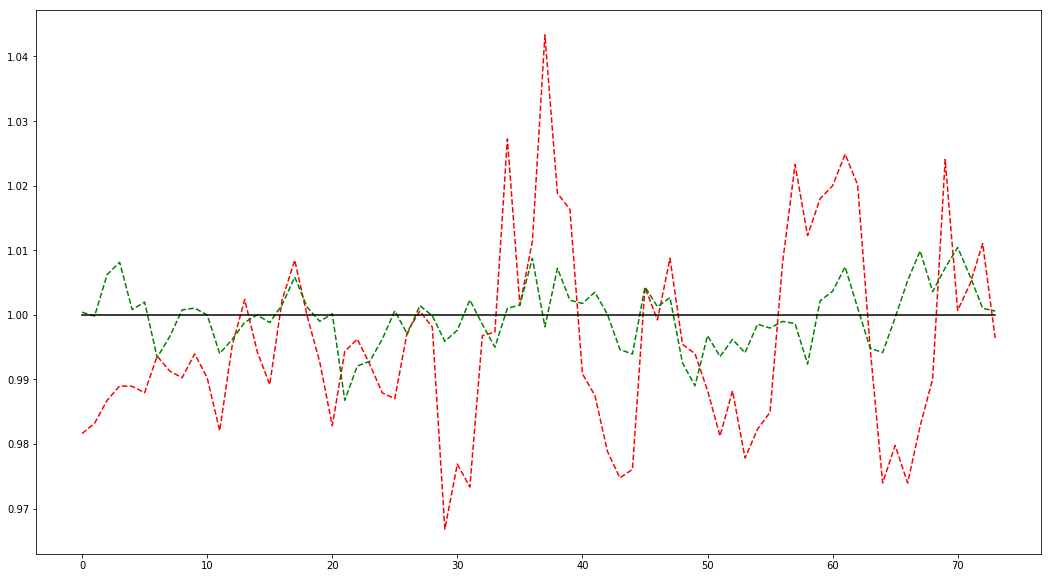

In [29]:
#Plotting flow ratio and membrane ratio computed above
t = np.arange(initialization_time, len(flowchannel)-1, 1.)
plt.plot(t, flow_movement_factor_list_per_object[0], 'r--',t, membrane_movement_factor_list_per_object[0], 'g--')
plt.plot(t, np.ones_like(t),'k-')
plt.show()

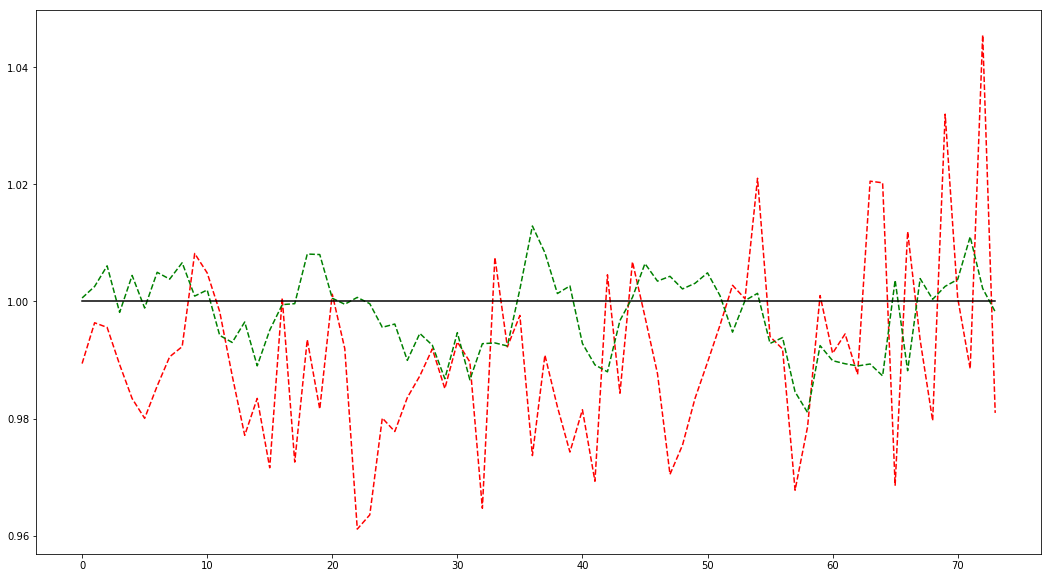

In [30]:
#Plotting flow ratio and membrane ratio computed above
t = np.arange(initialization_time, len(flowchannel)-1, 1.)
plt.plot(t, flow_movement_factor_list_per_object[1], 'r--',t, membrane_movement_factor_list_per_object[1], 'g--')
plt.plot(t, np.ones_like(t),'k-')
plt.show()

In [31]:
flow_movement_factor_list_per_object[0] = [list(x) for x in flow_movement_factor_list_per_object[0]]
flattened_flow_movement_factor_list0 = [val for sublist in flow_movement_factor_list_per_object[0] for val in sublist]

In [32]:
flow_movement_factor_list_per_object[1] = [list(x) for x in flow_movement_factor_list_per_object[1]]
flattened_flow_movement_factor_list1 = [val for sublist in flow_movement_factor_list_per_object[1] for val in sublist]

In [33]:
corr0 = []
for start in range(0,len(flow_movement_factor_list_per_object[0])-30,1):
    c0,p0 = pearsonr(flattened_flow_movement_factor_list0[start:], membrane_movement_factor_list_per_object[0][start:])
    print('start: ', start+initialization_time, '; ','till ',len(segchannel), c0, p0)
    corr0.append(c0)

start:  0 ;  till  75 0.289255904799 0.0124335765157
start:  1 ;  till  75 0.29302241215 0.0118742209656
start:  2 ;  till  75 0.294826559093 0.011935184558
start:  3 ;  till  75 0.311525703582 0.00818051639441
start:  4 ;  till  75 0.331856676611 0.00500788473366
start:  5 ;  till  75 0.334639666425 0.00494704562741
start:  6 ;  till  75 0.340470270829 0.00449799418345
start:  7 ;  till  75 0.341017405848 0.00474281839728
start:  8 ;  till  75 0.339104994729 0.00534767143901
start:  9 ;  till  75 0.341346442969 0.00539027358675
start:  10 ;  till  75 0.34257105942 0.00558956671142
start:  11 ;  till  75 0.343722295247 0.00581279127099
start:  12 ;  till  75 0.332438203483 0.00829324533357
start:  13 ;  till  75 0.332436229593 0.00885502893928
start:  14 ;  till  75 0.333702353347 0.00917065441389
start:  15 ;  till  75 0.333994399808 0.00973020958309
start:  16 ;  till  75 0.333302224241 0.0105682691775
start:  17 ;  till  75 0.33189753619 0.0116624222144
start:  18 ;  till  75 0.3224

In [34]:
corr1 = []
for start in range(0,len(flow_movement_factor_list_per_object[1])-30,1):
    c1,p1 = pearsonr(flattened_flow_movement_factor_list1[start:], membrane_movement_factor_list_per_object[1][start:])
    print('start: ', start+initialization_time, '; ','till ',len(segchannel), c1, p1)
    corr1.append(c1)

start:  0 ;  till  75 -0.0073114406861 0.950701856974
start:  1 ;  till  75 -0.00696182919228 0.953385456944
start:  2 ;  till  75 -0.0107026279539 0.928900755252
start:  3 ;  till  75 -0.0166749799252 0.890223456729
start:  4 ;  till  75 -0.0166172931907 0.89139732572
start:  5 ;  till  75 -0.0104472860244 0.932103526663
start:  6 ;  till  75 -0.00868939769518 0.943933036171
start:  7 ;  till  75 -0.00368448978795 0.976392940353
start:  8 ;  till  75 -0.00366494723468 0.976700794819
start:  9 ;  till  75 -0.00591642039871 0.96269289842
start:  10 ;  till  75 -0.0152397029755 0.904862108698
start:  11 ;  till  75 -0.0254583300452 0.843002143195
start:  12 ;  till  75 -0.0220868847776 0.864700485897
start:  13 ;  till  75 -0.0237367869824 0.85591199797
start:  14 ;  till  75 -0.0252518966034 0.848121200554
start:  15 ;  till  75 -0.0338459238886 0.799120199039
start:  16 ;  till  75 -0.0406959093871 0.761653870959
start:  17 ;  till  75 -0.0439242876423 0.745611903536
start:  18 ;  till

Text(0,0.5,'correlation')

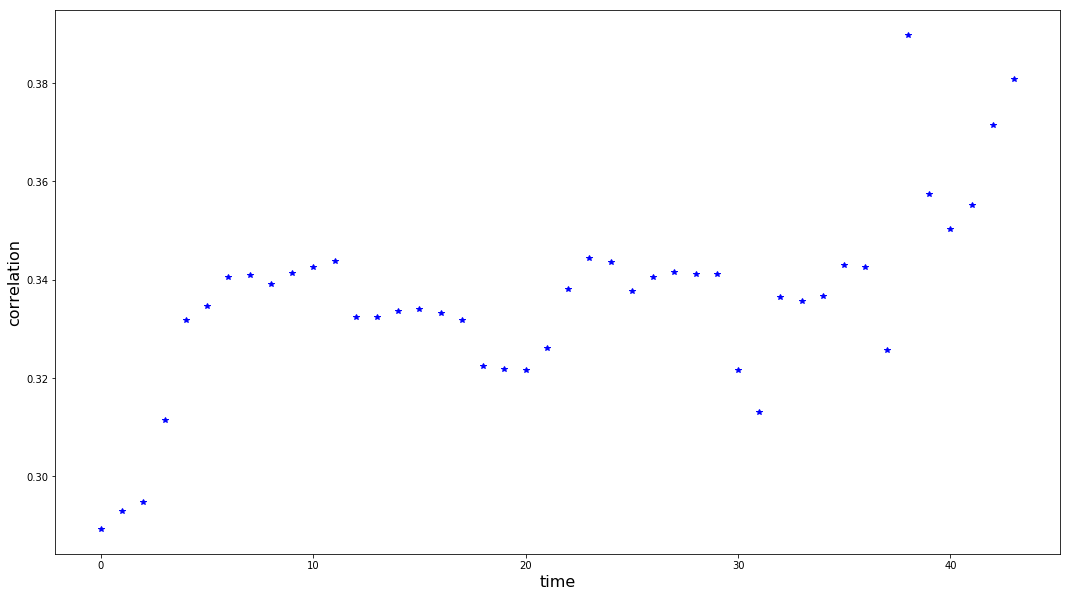

In [35]:
pyplot.plot(corr0, 'b*')
plt.xlabel('time', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)

Text(0,0.5,'correlation')

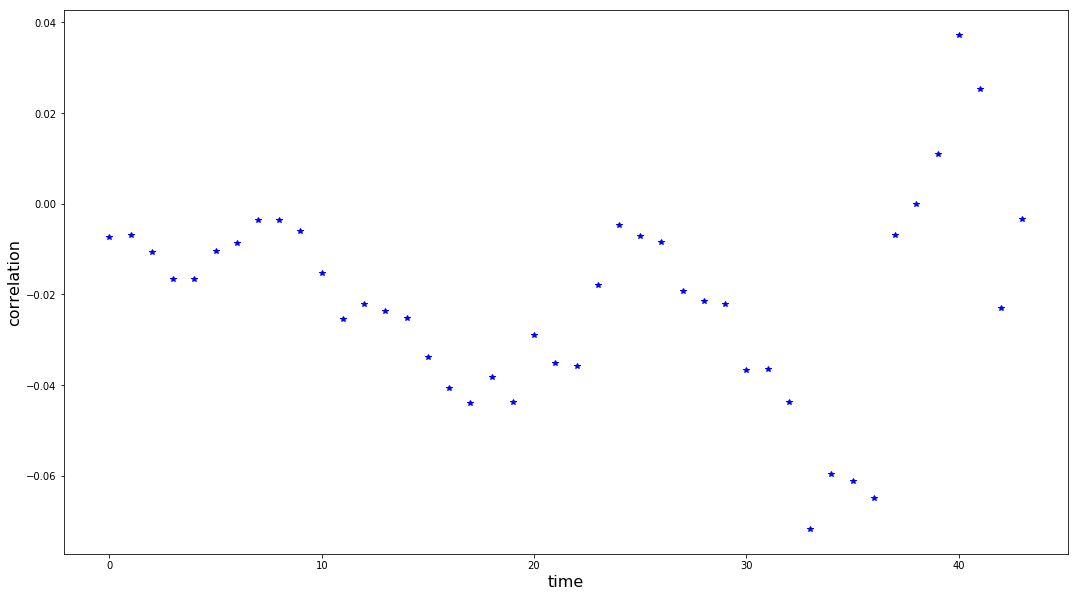

In [36]:
pyplot.plot(corr1, 'b*')
plt.xlabel('time', fontsize = 16)
plt.ylabel('correlation', fontsize = 16)

In [37]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

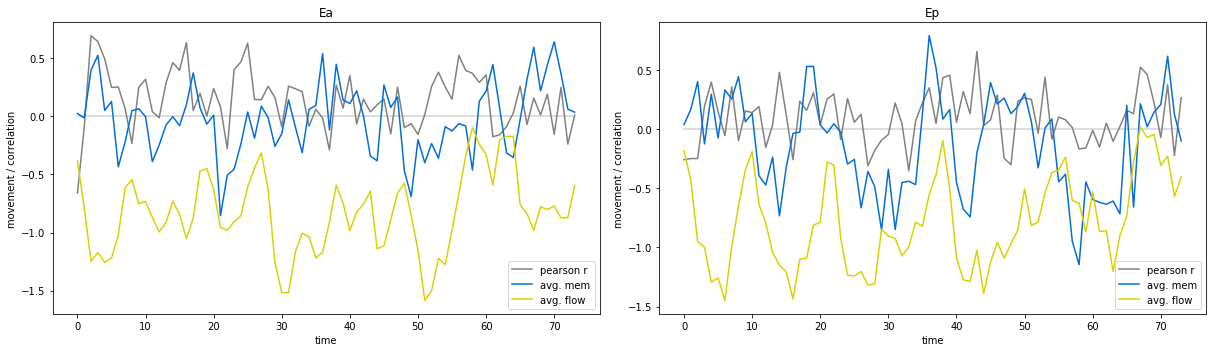

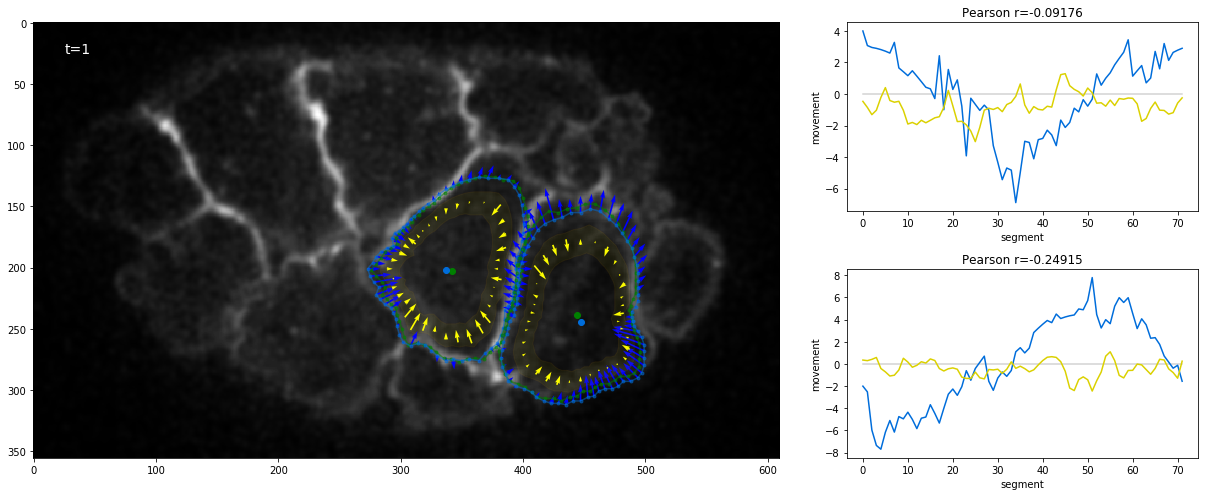

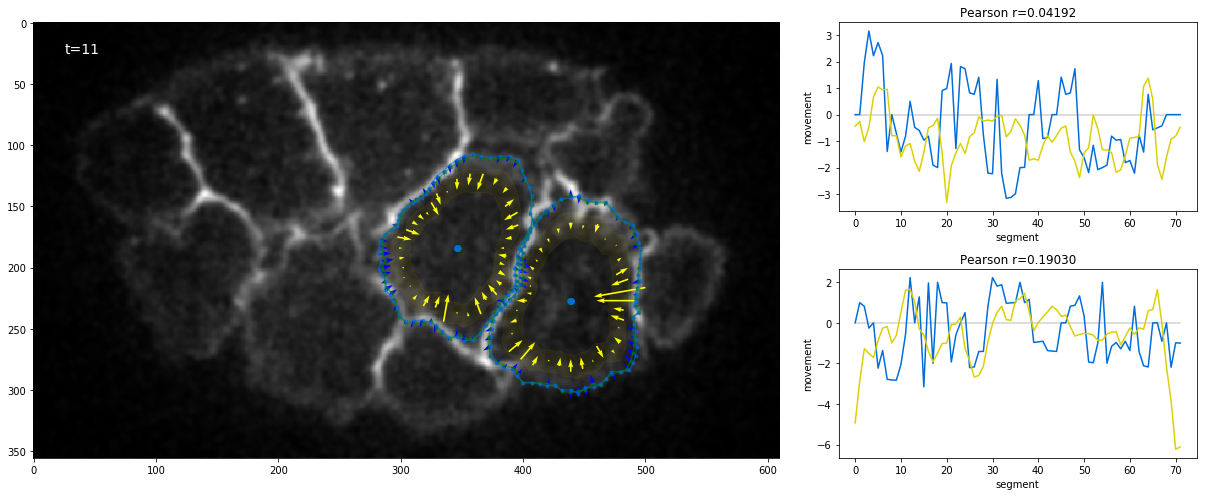

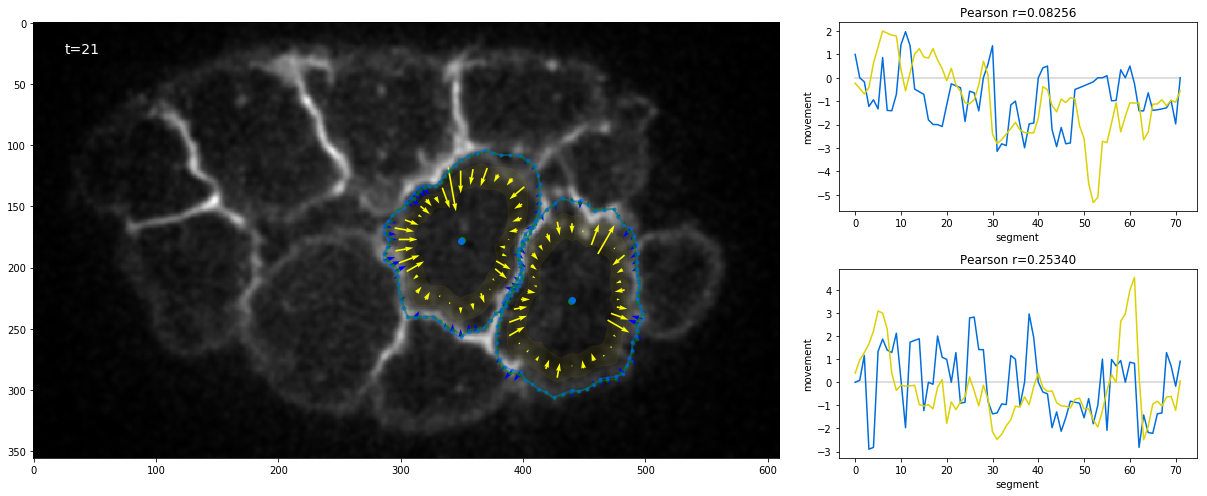

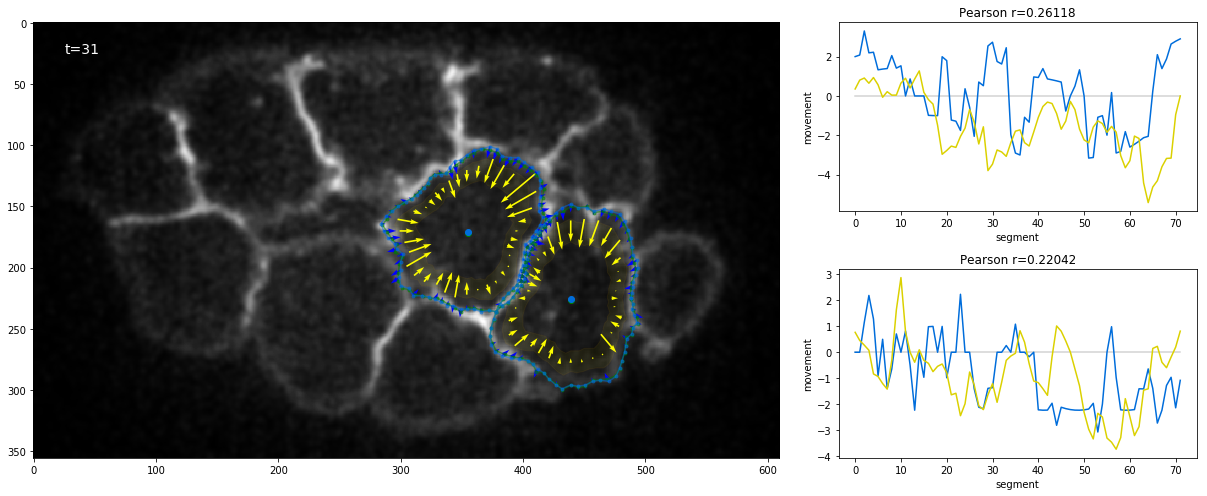

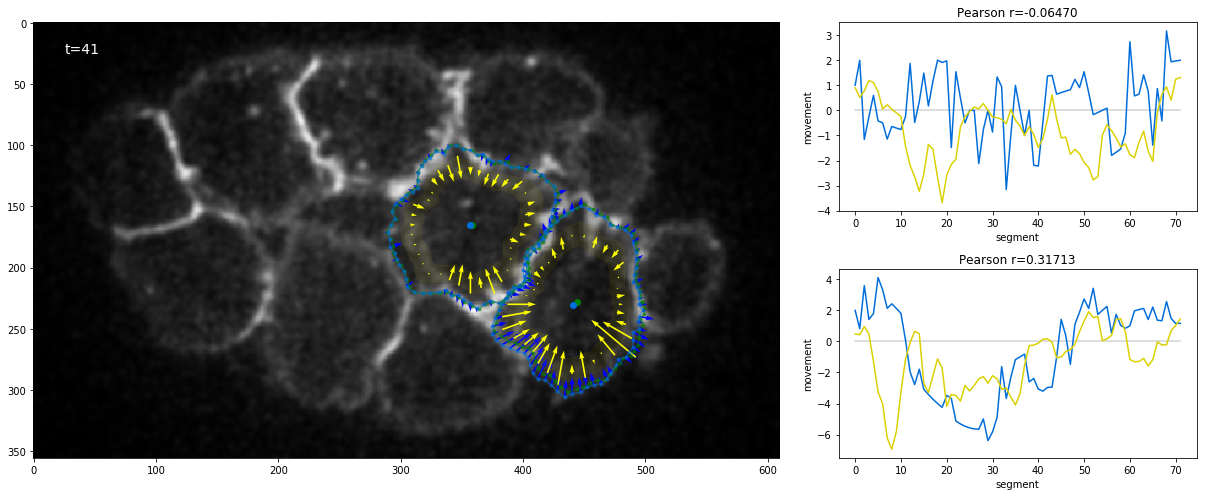

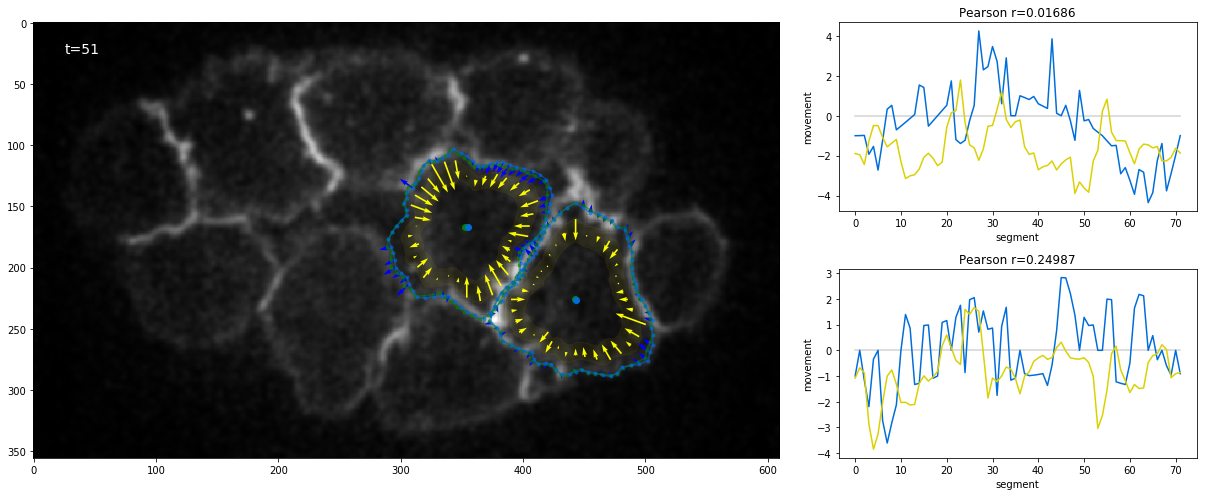

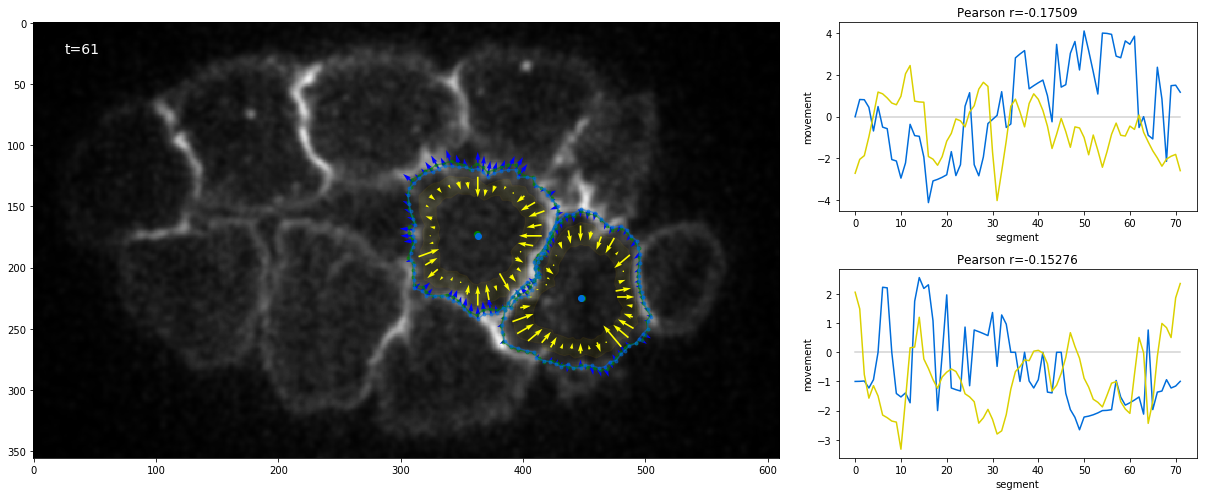

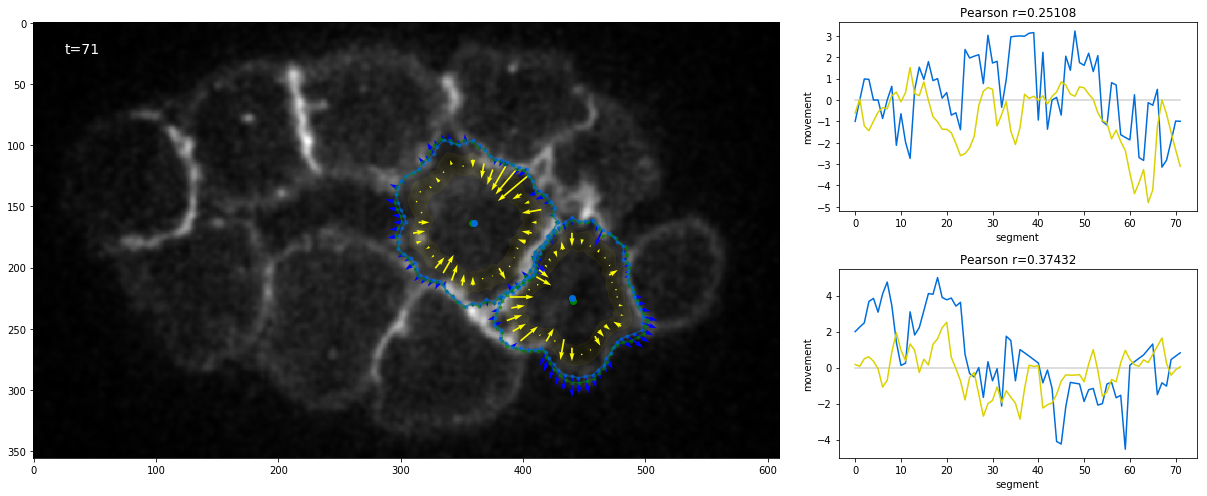

In [38]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[0]), color='lightgray')
ax.plot(correlation_per_frame_per_object[0], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[0], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[0], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
ax = plt.subplot(122)
ax.set_title(data.object_names[1])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[1]), color='lightgray')
ax.plot(correlation_per_frame_per_object[1], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[1], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[1], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
fig.tight_layout()

pylab.rcParams['figure.figsize'] = (17, 7)
offset = 0
stepsize = 2
show_projected = True

for t in range(1,len(flowchannel),10):
    fig = plt.figure()
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot(233)
    ax3 = plt.subplot(236)

    ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
    ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

    for obj in objects:
        # center points
        ax.plot(data.object_seedpoints[obj][t+1][0],data.object_seedpoints[obj][t+1][1], 'o', color='green')
        ax.plot(data.object_seedpoints[obj][t][0],data.object_seedpoints[obj][t][1], 'o', color='#%02x%02x%02x'%(0,109,219))
        
        # polygones (membrane and annulus)
        poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
        poly_membrane_t2 = geometry.Polygon(membrane_polygones_per_object[obj][t+1])
        poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
        poly_annulus_middle = geometry.Polygon(annulus_middle_polygones_per_object[obj][t])

        plot_coords( ax, poly_membrane_t2.exterior, 'green', alpha=.5 )
        plot_coords( ax, poly_membrane.exterior, '#%02x%02x%02x'%(0,109,219) )

        patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
        ax.add_patch(patch_annulus)

        # membrane quivers
        mem_base_x = [p[0] for p in membrane_polygones_per_object[obj][t]]
        mem_base_y = [p[1] for p in membrane_polygones_per_object[obj][t]]
        if (show_projected):
            mem_vec = [column_vectors[i]*projected_mem_vecs_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            mem_vec_x = [v[0] for v in mem_vec]
            mem_vec_y = [-v[1] for v in mem_vec]
        else:
            mem_vec_x = [v[0] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
            mem_vec_y = [-v[1] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
        ax.quiver(mem_base_x, 
                  mem_base_y, 
                  mem_vec_x, 
                  mem_vec_y, 
                  width=0.0022, scale=flowchannel.shape[1]/2., color='blue')
        
        # flow quivers
        flow_base_x = [p[0] for p in annulus_middle_polygones_per_object[obj][t]]
        flow_base_y = [p[1] for p in annulus_middle_polygones_per_object[obj][t]]
        if (show_projected):
            flow_vec = [column_vectors[i]*projected_avg_flows_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            flow_vec_x = [v[0] for v in flow_vec]
            flow_vec_y = [-v[1] for v in flow_vec]
        else:
            flow_vec_x = [v[0] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
            flow_vec_y = [-v[1] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
        ax.quiver(flow_base_x[offset::stepsize], 
                  flow_base_y[offset::stepsize], 
                  flow_vec_x[offset::stepsize], 
                  flow_vec_y[offset::stepsize], 
                  pivot='mid', width=0.0022, scale=flowchannel.shape[1]/4., color='yellow')
        
    # LINEPLOT
    # ========
    ax2.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[0][t])
    ax2.set_xlabel('segment')
    ax2.set_ylabel('movement')
    ax2.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[0][t]), color='lightgray')
    ax2.plot(projected_mem_vecs_per_frame_per_object[0][t], color='#%02x%02x%02x'%(0,109,219))
    ax2.plot(projected_avg_flows_per_frame_per_object[0][t], color='#%02x%02x%02x'%(219,209,0))

    ax3.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[1][t])
    ax3.set_xlabel('segment')
    ax3.set_ylabel('movement')
    ax3.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[1][t]), color='lightgray')
    ax3.plot(projected_mem_vecs_per_frame_per_object[1][t], color='#%02x%02x%02x'%(0,109,219))
    ax3.plot(projected_avg_flows_per_frame_per_object[1][t], color='#%02x%02x%02x'%(219,209,0))

    fig.tight_layout()